This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from flight_querying import query_flights
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up and retrieve the data from the database.
db_connect = query_flights()

In [2]:
# Make the data dictionary holder
data_dict = {
    "Time Delta": [],
    "SOC Delta": [],
    "Activity": [],
    "Average Power": [],
    "Id": [],
    "Unique Data Identifier": [],
    "temperature": [],
    "Visibility": [],
    "Wind Speed": []
}

# Create a increasing int variable to keep track of the Unique Data Identifier
unique_identifier = 0

In [3]:
def data_parser(parsing_dataframe):

    global unique_identifier

    # Get the current exercise
    current_exercise = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('activity')]
    id = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('id')]
    max_soc, min_soc = 0, 101
    power_list = [0]
    min_time, max_time = 100, 0

    # iterate over all the rows
    for index, row in parsing_dataframe.iterrows():

        # Get the data needed from the rows. Append the power
        new_exercise = row["activity"]
        soc = row["soc"]
        power_list.append(row["power"])
        time = row["time"]
        outside_temp = row["temperature"]
        visibility = row["visibility"]
        wind_speed = row["wind_speed"]

        # If the exercise changes or if the rows end.
        if current_exercise != new_exercise or index == len(parsing_dataframe) - 1:

            # Set the values 
            data_dict["Time Delta"].append(round(max_time - min_time, 2))
            data_dict["SOC Delta"].append(max_soc - min_soc)
            data_dict["Activity"].append(current_exercise)
            data_dict["Average Power"].append(round(sum(power_list)/len(power_list), 2))
            data_dict["Id"].append(id)
            data_dict["temperature"].append(outside_temp)
            data_dict["Visibility"].append(visibility)
            data_dict["Wind Speed"].append(wind_speed)
            data_dict["Unique Data Identifier"].append(unique_identifier)
            unique_identifier = unique_identifier + 1

            # Reset all the values
            max_soc, min_soc = soc, soc
            power_list.clear()
            max_time, min_time = time, time
        
        # SOC
        if soc >= max_soc:
            max_soc = soc
        if soc <= min_soc:
            min_soc = soc

        # TIME
        if time >= max_time:
            max_time = time
        if time <= min_time:
            min_time = time
        
        # Change current exercise
        current_exercise = new_exercise


In [4]:
# Flight IDs to include
flight_ids = [4620, 4929, 4940, 5019, 5021, 5034]

# Fetch data for specified flight IDs
# Remove NA values from each dataframe in the list and put it through the data parser
for ids in flight_ids:
    frame = db_connect.connect_flight_for_ml_data_prescription(ids)
    frame = frame[frame["activity"] != "NA"].reset_index()
    data_parser(frame)

# Concatenate data frames and shuffle the data
all_data = pd.DataFrame(data_dict)

In [5]:
# Split the data into train and test sets
train_data, test_data = train_test_split(all_data, test_size=0.3, random_state=42)

In [6]:
all_data.head()

,Time Delta,SOC Delta,Activity,Average Power,Id,Unique Data Identifier,temperature,Visibility,Wind Speed
0,0.98,3.166667,takeoff,52.62,4620,0,66.2,9.0,4
1,0.88,3.500000,climb,51.16,4620,1,64.4,9.0,6
2,1.28,2.000000,cruise,14.82,4620,2,66.2,9.0,4
3,1.18,0.000000,landing,0.69,4620,3,66.2,9.0,4
4,0.68,2.041667,takeoff,52.72,4620,4,64.4,9.0,6


In [7]:
print(f"Length train_x = {len(train_data)} \n Length train_y = {len(test_data)}")

Length train_x = 67 
 Length train_y = 29


One-Hot-Encoding of the Operations columns

In [8]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['Unique Data Identifier'] = df['Unique Data Identifier']
  return encoded

In [9]:
# Encode Train data
train_encoded = one_hot(train_data, "Activity", 'is')
final_train_x = pd.merge(train_data, train_encoded, on=["Unique Data Identifier"])
final_train_y = final_train_x["SOC Delta"].to_numpy()
final_train_x = final_train_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

# Encode Test data
test_encoded = one_hot(test_data, "Activity", 'is')
final_test_x = pd.merge(test_data, test_encoded, on=["Unique Data Identifier"])
final_test_y = final_test_x["SOC Delta"].to_numpy()
final_test_x = final_test_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

In [10]:
final_train_x

,Time Delta,Average Power,temperature,Visibility,Wind Speed,Activity_is_climb,Activity_is_cruise,Activity_is_descent,Activity_is_landing,Activity_is_power off stall,Activity_is_power on stall,Activity_is_slow flight,Activity_is_steep turns,Activity_is_takeoff
0,0.68,29.23,44.6,9.0,2,False,False,False,False,False,False,False,True,False
1,2.28,43.18,51.8,5.0,2,True,False,False,False,False,False,False,False,False
2,1.08,44.37,53.6,9.0,7,True,False,False,False,False,False,False,False,False
3,0.78,0.23,53.6,9.0,7,False,False,True,False,False,False,False,False,False
4,0.98,43.69,64.4,9.0,6,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.68,43.82,44.6,9.0,3,True,False,False,False,False,False,False,False,False
63,3.38,17.87,48.2,9.0,3,False,False,False,False,False,False,True,False,False
64,1.48,20.15,66.2,9.0,4,False,True,False,False,False,False,False,False,False
65,0.68,53.64,55.4,9.0,9,False,False,False,False,False,False,False,False,True


In [11]:
print(f"Length test_encoded = {len(test_encoded)} \n Length train_encoded = {len(train_encoded)}")

Length test_encoded = 29 
 Length train_encoded = 67


In [12]:
print(f"Length train_x = {len(final_train_x)} \n Length train_y = {len(final_train_y)}")

Length train_x = 67 
 Length train_y = 67


In [13]:
print(f"Length test_x = {len(final_test_x)} \n Length test_y = {len(final_test_y)}")

Length test_x = 29 
 Length test_y = 29


In [14]:
print(final_train_y)

[ 2.          8.125       4.          0.          4.          0.
  1.          0.5         0.5         9.04166667  4.625       0.
  1.          3.          2.5         3.          0.5         8.
  2.875       4.29166667  0.          3.5         6.          3.
  3.          3.          0.          2.          3.          5.
  1.          2.          0.          1.5         0.5         8.70833333
  2.          2.          3.          5.          1.5         0.
  7.          1.          4.          3.          3.          2.04545455
  2.5         9.125       3.         28.          3.5         5.
  0.          2.          3.5         3.          0.          1.
  8.          0.          3.          5.          3.          2.
  1.04166667]


Machine Learning Model Implementation

In [15]:
print("Unique classes in final_train_y:", np.unique(final_train_y))

Unique classes in final_train_y: [ 0.          0.5         1.          1.04166667  1.5         2.
  2.04545455  2.5         2.875       3.          3.5         4.
  4.29166667  4.625       5.          6.          7.          8.
  8.125       8.70833333  9.04166667  9.125      28.        ]


In [16]:
# Replace "28" with "11"
final_train_y_replaced = np.where(final_train_y == 28, 11, final_train_y)

# Print the updated unique classes
print("Unique classes in final_train_y (after replacing '28' with '11'):", np.unique(final_train_y_replaced))

Unique classes in final_train_y (after replacing '28' with '11'): [ 0.          0.5         1.          1.04166667  1.5         2.
  2.04545455  2.5         2.875       3.          3.5         4.
  4.29166667  4.625       5.          6.          7.          8.
  8.125       8.70833333  9.04166667  9.125      11.        ]


In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create an XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=30, max_depth=3, learning_rate=0.45)

# Train the model on the training data
xgb_model.fit(final_train_x, final_train_y_replaced)

# Make predictions on the test data
y_pred = xgb_model.predict(final_test_x)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(final_test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(final_test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(xgb_model, final_train_x, final_train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(final_test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(final_test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 5  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(xgb_model, final_train_x, final_train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')


Mean Squared Error (MSE): 3.9031775553337003
Coefficient of Determination (R-squared): 0.6911119771775462
Cross-validated R-squared: 0.6823461280544858
Mean Absolute Error (MAE): 0.960800254481963
Root Mean Squared Error (RMSE): 1.9756461108542946
K-fold Cross-validated R-squared: 0.7486408785596355


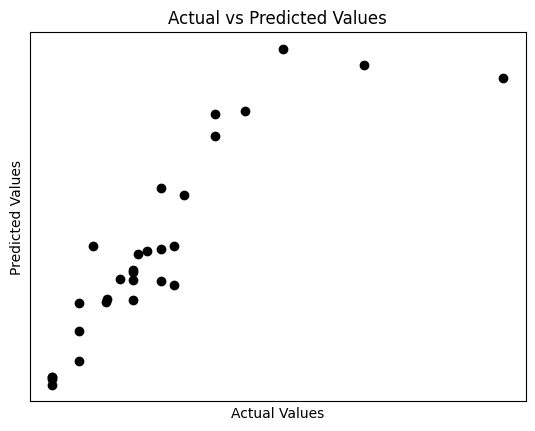

In [19]:
import matplotlib.pyplot as plt

# Plot outputs
plt.scatter(final_test_y, y_pred, color="black")

plt.xticks(())
plt.yticks(())

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

plt.show()

Feature Importances:
                        Feature  Importance
3                    Visibility    0.294520
0                    Time Delta    0.241163
1                 Average Power    0.175920
5             Activity_is_climb    0.166468
6            Activity_is_cruise    0.051456
9   Activity_is_power off stall    0.017337
4                    Wind Speed    0.015161
8           Activity_is_landing    0.009818
13          Activity_is_takeoff    0.009695
2                   temperature    0.008811
12      Activity_is_steep turns    0.004977
10   Activity_is_power on stall    0.003280
11      Activity_is_slow flight    0.000915
7           Activity_is_descent    0.000479


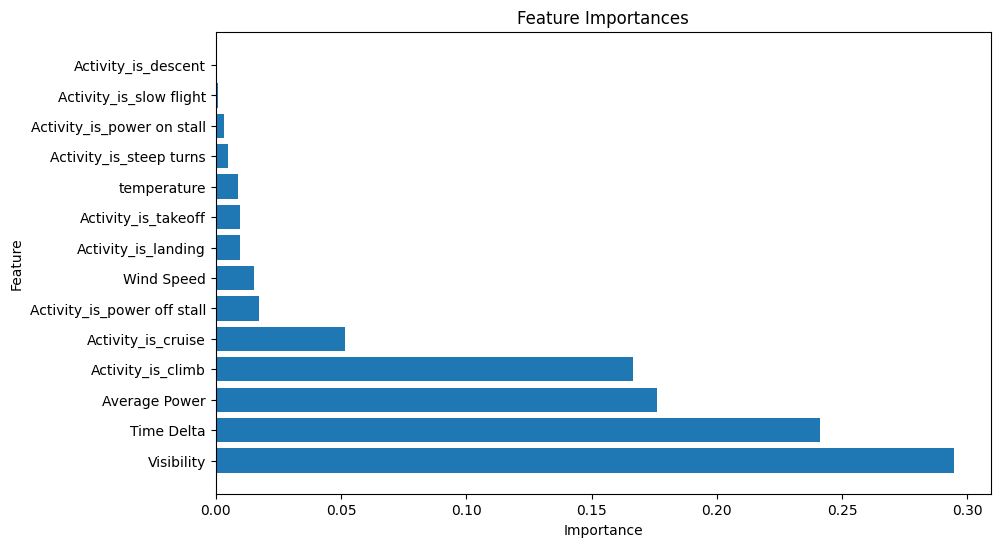

In [21]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get the corresponding feature names
feature_names = final_train_x.columns

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()